In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-09-08 06:09:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-08 06:09:58 (75.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2022-09-08 06:10:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.13.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   232MB/s    in 0.7s    

2022-09-08 06:10:46 (232 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import tensorflow as tf

In [5]:
img_size = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent, 
                                                                            label_mode = "categorical", 
                                                                            image_size = img_size)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical", 
                                                                image_size = img_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [10]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

In [17]:
# Create BaseModel
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create Model
input = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(input)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
output = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = tf.keras.Model(input, output)

# Compile

model_2.compile(loss = "categorical_crossentropy", 
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), 
                metrics = ["accuracy"])

In [18]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [19]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220908-064413
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0002 - accuracy: 0.3227
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 423ms/step - loss: 2.0002 - accuracy: 0.3227 - val_loss: 1.5690 - val_accuracy: 0.6036
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3593 - accuracy: 0.6760
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 346ms/step - loss: 1.3593 - accuracy: 0.6760 - val_loss: 1.1459 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0756 - accuracy: 0.7400
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 379ms/step - loss: 1.0756 - accuracy: 0.7400 - val_loss: 0.8990 - val_accuracy: 0.7632
Ep

In [20]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 78ms/step - loss: 0.7075 - accuracy: 0.8144


[0.7075203061103821, 0.8144000172615051]

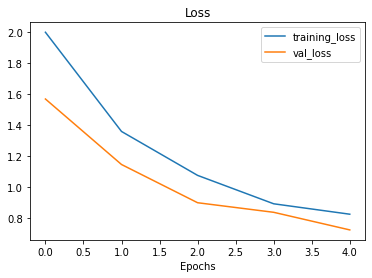

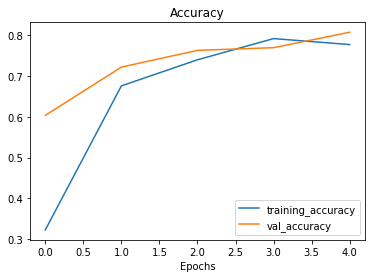

In [21]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [22]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path) 
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.7075 - accuracy: 0.8144


In [23]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [24]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [26]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer.name, layer.trainable)  

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [27]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
print(len(model_2.trainable_variables))

12


In [30]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220908-070050
Epoch 5/10
24/24 [==============================] - 18s 436ms/step - loss: 0.6982 - accuracy: 0.8053 - val_loss: 0.6056 - val_accuracy: 0.7928
Epoch 6/10
24/24 [==============================] - 8s 316ms/step - loss: 0.5447 - accuracy: 0.8360 - val_loss: 0.5774 - val_accuracy: 0.8207
Epoch 7/10
24/24 [==============================] - 8s 315ms/step - loss: 0.4913 - accuracy: 0.8427 - val_loss: 0.5428 - val_accuracy: 0.8339
Epoch 8/10
24/24 [==============================] - 8s 325ms/step - loss: 0.4675 - accuracy: 0.8547 - val_loss: 0.5774 - val_accuracy: 0.8125
Epoch 9/10
24/24 [==============================] - 9s 347ms/step - loss: 0.4099 - accuracy: 0.8733 - val_loss: 0.5390 - val_accuracy: 0.8306
Epoch 10/10
24/24 [==============================] - 9s 343ms/step - loss: 0.3341 - accuracy: 0.9093 - val_loss: 0.5071 - val_accuracy: 0.8355


In [31]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3226666748523712, 0.6759999990463257, 0.7400000095367432, 0.7919999957084656, 0.7773333191871643, 0.8053333163261414, 0.8360000252723694, 0.8426666855812073, 0.8546666502952576, 0.8733333349227905, 0.909333348274231]


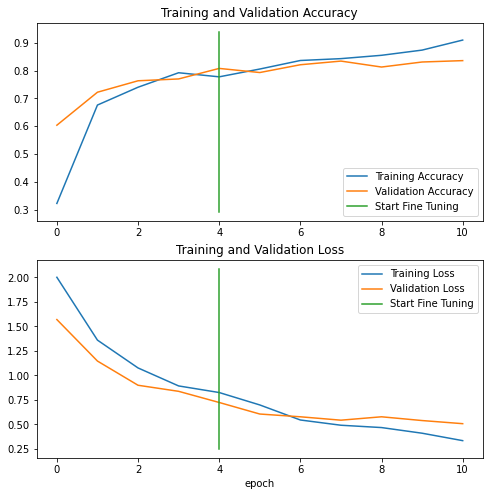

In [33]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

In [34]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4943 - accuracy: 0.8332


In [35]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=AvsbtSUu8Wnm2O9i51V1u78IkK4xly&prompt=consent&access_type=o

In [36]:
# View previous experiments
!tensorboard dev list

https://tensorboard.dev/experiment/Qi3c7O2XSM2ZzqNf7Enj0w/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   Qi3c7O2XSM2ZzqNf7Enj0w
	Created              2022-09-08 07:12:34 (1 minute ago)
	Updated              2022-09-08 07:12:37 (1 minute ago)
	Runs                 6
	Tags                 5
	Scalars              96
	Tensor bytes         0
	Binary object bytes  2618273
Total: 1 experiment(s)


In [ ]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q